In [3]:

# install StellarGraph if running on Google Colab
!pip install -q stellargraph
!pip install numpy 
!pip install pandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import sys
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
batch_size = 50
num_samples = [10, 5]
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [6]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [7]:
set(node_subjects)

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

In [8]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.1, test_size=None, stratify=node_subjects
)

In [9]:


Counter(train_subjects)
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)

In [10]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

In [11]:
train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

In [12]:

graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

In [13]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [14]:

model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [16]:

history = model.fit(
    train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/20
6/6 - 4s - loss: 1.8757 - acc: 0.2815 - val_loss: 1.6907 - val_acc: 0.3495 - 4s/epoch - 675ms/step
Epoch 2/20
6/6 - 4s - loss: 1.6148 - acc: 0.4333 - val_loss: 1.5452 - val_acc: 0.5094 - 4s/epoch - 673ms/step
Epoch 3/20
6/6 - 4s - loss: 1.4642 - acc: 0.6222 - val_loss: 1.4093 - val_acc: 0.6493 - 4s/epoch - 632ms/step
Epoch 4/20
6/6 - 4s - loss: 1.3071 - acc: 0.7852 - val_loss: 1.2735 - val_acc: 0.7293 - 4s/epoch - 664ms/step
Epoch 5/20
6/6 - 4s - loss: 1.1767 - acc: 0.8148 - val_loss: 1.1698 - val_acc: 0.7740 - 4s/epoch - 706ms/step
Epoch 6/20
6/6 - 2s - loss: 1.0427 - acc: 0.8926 - val_loss: 1.0877 - val_acc: 0.7920 - 2s/epoch - 392ms/step
Epoch 7/20
6/6 - 3s - loss: 0.9379 - acc: 0.9370 - val_loss: 1.0134 - val_acc: 0.7929 - 3s/epoch - 502ms/step
Epoch 8/20
6/6 - 3s - loss: 0.8354 - acc: 0.9444 - val_loss: 0.9413 - val_acc: 0.8007 - 3s/epoch - 503ms/step
Epoch 9/20
6/6 - 2s - loss: 0.7438 - acc: 0.9556 - val_loss: 0.8988 - val_acc: 0.8027 - 2s/epoch - 349ms/step
Epoch 10/2

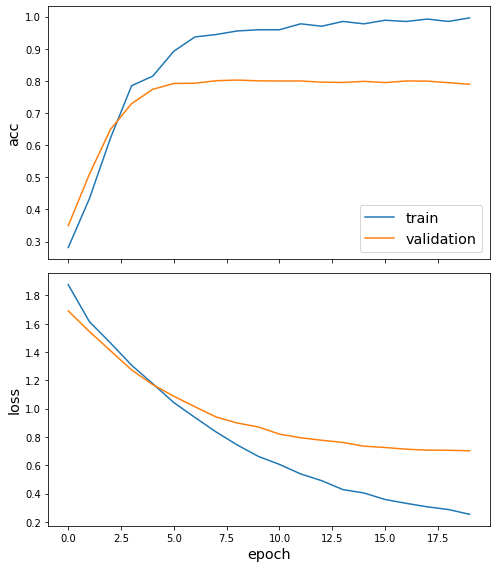

In [17]:
sg.utils.plot_history(history)

In [18]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

49/49 [==============================] - 2s 39ms/step - loss: 0.6916 - acc: 0.7937

Test Set Metrics:
	loss: 0.6916
	acc: 0.7937


In [19]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

55/55 [==============================] - 2s 38ms/step


In [20]:
node_predictions = target_encoding.inverse_transform(all_predictions)

In [21]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(10)

,Predicted,True
31336,Theory,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Theory,Neural_Networks
31349,Theory,Neural_Networks
1106418,Theory,Theory


In [22]:
Gnx = G.to_networkx(feature_attr=None)
for nid, pred, true in zip(df.index, df["Predicted"], df["True"]):
    Gnx.nodes[nid]["subject"] = true
    Gnx.nodes[nid]["PREDICTED_subject"] = pred.split("=")[-1]

for nid in train_subjects.index:
    Gnx.nodes[nid]["isTrain"] = True

for nid in test_subjects.index:
    Gnx.nodes[nid]["isTrain"] = False

for nid in Gnx.nodes():
    Gnx.nodes[nid]["isCorrect"] = (
        Gnx.nodes[nid]["subject"] == Gnx.nodes[nid]["PREDICTED_subject"]
    )

In [23]:
pred_fname = "pred_n={}.graphml".format(num_samples)
nx.write_graphml(Gnx, os.path.join(dataset.data_directory, pred_fname))

In [24]:
embedding_model = Model(inputs=x_inp, outputs=x_out)
emb = embedding_model.predict(all_mapper)
emb.shape

55/55 [==============================] - 3s 49ms/step


(2708, 32)

In [25]:
X = emb
y = np.argmax(target_encoding.transform(node_subjects), axis=1)

In [26]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_subjects.index)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_subjects.index)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


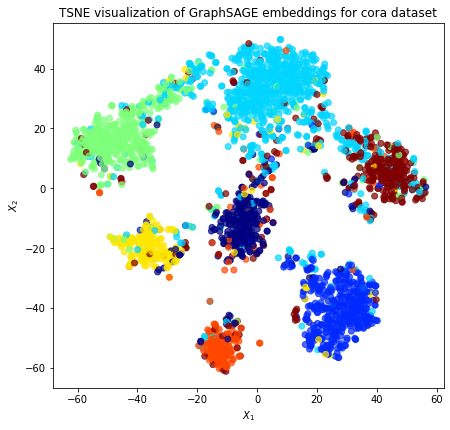

In [27]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings for cora dataset".format(transform.__name__)
)
plt.show()